<a href="https://colab.research.google.com/github/ITMK/DataLitMT/blob/main/colab_companion_notebook_embedding_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

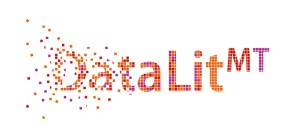

# Data Evaluation Companion Notebook for Embedding-Based MT Quality Evaluation Metrics


This is a companion notebook for our [Basic](https://colab.research.google.com/drive/1x33BY4qjWUXo3yU7F-raAN9t70TDOm_H?usp=sharing
 ) and [Advanced](https://colab.research.google.com/drive/1UgsqgN-6yfDESU7Geei4RXzJShEQNViZ?usp=sharing
  ) MT Quality Evaluation notebooks, in which we take a closer look at the concept of *word embeddings*. Specifically, we'll take a look at vectorizing words for use in machine learning models (such as neural machine translation systems, large language models such as ChatGPT or the embedding-based MT quality scores covered in our MT Quality Evaluation notebooks). Modern machine learning models in Natural Language Processing (NLP) cannot process natural language directly, but need to convert it into numeric vector representations (embeddings) first. The word embedding model we explore in this notebook takes words from a natural language vocabulary and converts them into such vectors. The word embedding method was developed by [Mikolov et al. 2013: Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781).

## 0 Housekeeping
Run the cell below to perform the necessary housekeeping steps.

In [ ]:
# Upgrade to the newest version of pip
!pip install --upgrade pip

In [ ]:
# Import necessary requirements
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Loading the Word Embedding Model

In this notebook, we'll use a pre-trained [GloVe](https://nlp.stanford.edu/projects/glove/) word embedding model provided by the [Stanford NLP Group](https://nlp.stanford.edu/). The model we'll use is called *glove.6B.100d* – it contains about 6 billion words from Wikipedia and the Gigaword corpus (a corpus containing news articles from Associated Press, the New York Times, etc.) and about 400,000 unique words and corresponding word vectors, each of dimensionality 100. Run the code below to import the GloVe model (this may take a few minutes).

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip glove.6B.zip

Next, we will define a function `create_word_embeddings` to compile the embedding. We could then use this function to load any glove model we like.

In [ ]:
# load the whole embedding into memory
word_embeddings={}       
def create_word_embeddings(glove):
  with open(glove,'r') as f:
    for line in f:
      values=line.split()
      word=values[0]
      vectors=np.asarray(values[1:],'float32')
      word_embeddings[word]=vectors
  f.close()
  print('Loaded %s word vectors.' % len(word_embeddings))

In the cell below, we load our glove model `glove.6B.100d.txt` as word embeddings.

In [ ]:
create_word_embeddings('glove.6B.100d.txt')

Loaded 400001 word vectors.


That's it. You're ready to go!

## 1 Exploring the word embedding model
We now have a pre-trained word embedding model which we can explore. A trained word embedding model is also called an *embedding matrix*. The size of this embedding matrix is the number of unique words in the model (the vocabulary) times the number of neurons in the hidden layer of the neural network used to train the word embedding model (the *embed size*). The number of hidden units corresponds to the dimensionality of the word vectors in the model, which in our case is 100. So, the size of our embedding matrix is $400.000\;\times\;100 = 40.000.000$. In other words, our pre-trained GloVe word embedding model/embedding matrix has a matrix size of 40 million. To get acquainted with the model, let's first have a look at a list of the 150 most frequent words in the model. This is what the code below generates (don't be surprised, there will be a lot of function words in the upper part of the list).

In [ ]:
# Generate a list of the 150 most frequent words in the model
list(word_embeddings.keys())[:150]

## 2 Exploring individual word vectors
We can query our word embedding model/embedding matrix like a look-up table, i.e., we can ask the model to look up a certain word and it will return the word vector for this word. This is what the code below does. The output will be an array of 100 floating-point numbers, each representing one vector dimension (remember, the vectors in this model are 100-dimensional). Let's look up the word vector for 'government', which is listed as one of the 150 most frequent words in the model. Feel free to modify this code to explore vectors for other words in our model.

In [ ]:
# Display individual word vectors
word_embeddings['government']

Vector representations such as these are what our embedding-based MT quality evaluation metrics actually process. You can think of our word embedding model/embedding matrix as a dictionary. We present the MT quality metric with a word such as 'government'. Since the metric cannot process such natural language words, it will look up the vector of the word 'government' in the embedding matrix and use this vector representation for further processing.

## 3 Exploring the most similar words
We can also explore semantic similarities between words. In the code cell below, we define a function `find_closest_embedding` to find the most similar words to a word of our choosing.

In [ ]:
# define (euclidean) distance function 
def find_closest_embeddings(embedding): 
    return sorted(word_embeddings.keys(), key=lambda word: spatial.distance.euclidean(word_embeddings[word], embedding))

The code below gives us the word most similar to the word *father* (according to what our model has learned from the underlying data). You can use any words you like in order to explore semantic similarities in the model, but this  works probably best if we use words from highly structured conceptual systems such as kinship relations. In the code cell below, the [1:2] at the end of the code line indicates that we want to print one (the next) closest word to father.

In [ ]:
# Query the model for the word most similar to the word 'father'
find_closest_embeddings(word_embeddings["father"])[1:2]

['brother']

Run the code cell below to print the 10 most similar words to the word *father* by now calling words 1 through 11 ([1:11]).

In [ ]:
# Query the model for the 10 most similar words to the word 'father'
find_closest_embeddings(word_embeddings["father"])[1:11]

As you can see, our word embedding model may display an ‘understanding’ of certain words which can be very close to our own understanding of these words. You may wonder how these word similarities are actually calculated and interpreted. Remember that the individual words in our model are represented by high-dimensional vectors. In order to establish the similarity between two words, we must therefore establish the distance between the two vectors representing these words. In this notebook, we do this by calculating the Euclidean distance between the vectors (as you can see from the code snippet `spatial.distance.euclidean` in section 5).

## 4 Exploring the least similar words
Theoretically, we can also explore the dissimilarities between words (although, as you will see, the results may not make that much sense to us). The code below gives us the 10 words which, according to our model, are the least similar to the word *father*.

In [ ]:
# Query the words to find the least similar word to 'father'
find_closest_embeddings(-word_embeddings['father'])[1:11]

['nizhal']

## 5 Calculating the similarity between two specific words
We can also calculate similarity (or dissimilarity) scores for two specific words. For example, the code below will give us a numeric similarity value for the two words *father* and *son* (again calculated using the spatial Euclidean distance). Another possibility to measure the distance between the two vectors is to calculate the cosine similarity between them (this is what the BERTScore covered in our main notebooks on automatic MT quality evaluation does). We will not discuss the difference between Euclidean distance and cosine similarity in this notebook. If you want to know more about this topic (and are not afraid of some math), check out [this article](https://cmry.github.io/notes/euclidean-v-cosine).

In [ ]:
# Calculate semantic similarity between words
spatial.distance.euclidean(word_embeddings["father"], word_embeddings["son"])

2.341798782348633

Now, we calculate the similarity between the words *father* and *government*.

In [ ]:
# Calculate semantic similarity between words
spatial.distance.euclidean(word_embeddings["father"], word_embeddings["government"])


As you can see, we obtain a higher Euclidean distance value for the similarity between the words *father* and *government*. The higher the Euclidean distance between two vectors is, the less similar are the words represented by these vectors. In other words, our word embedding model knows that the two words *father* and *son* are more similar to each other than the words *father* and *government*.

# 6 Visualising the (dis)similarity between multiple words

We can also visualise the similarity or dissimilarity between two or more word vectors. For the sake of simplicity, let us assume that each dimension of a word vector corresponds to a certain semantic feature (such as *human*, *kinship*, *substance* or *action*). Mind that this is actually an oversimplification, but we accept this for didactic purposes here. So, if two words share a certain semantic feature, we'd expect them to have similar values for the dimension representing this feature.  
If you run the code below, you will see a visual representation of the 100 dimensions of the similar words *father* and *son* together with the representation of the dissimilar word *government*. Create the representations and inspect the individual vector dimensions.

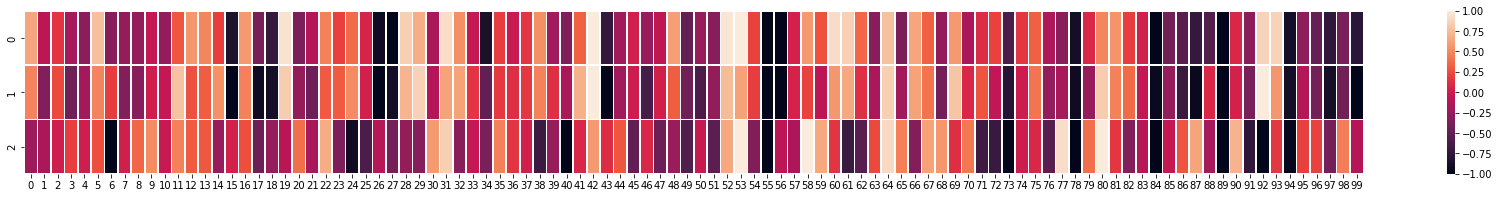

In [ ]:
# Import the libraries required to visualise the word embedding vectors
import seaborn as sns

# Create the visual representations
plt.figure(figsize=(30,3))
sns.heatmap([word_embeddings["father"], word_embeddings["son"], word_embeddings["government"]], xticklabels=True, yticklabels=True, cbar=True,
            vmin=-1, vmax=1, linewidths=0.7)
plt.show()

The first two rows (labelled *0* and *1*) are the visual representations of the 100-dimensional vectors for *father* and *son* and the third row (labelled *2*) is the representation of *government*. The values of the individual dimensions are scaled to a range between −1 and 1, corresponding to the colours you see on the right. Equal colours mean equal values for the respective dimension. If you inspect the representations carefully, you will see that *father* and *son* share many dimensions with similar colour coding whereas this is not the case for the word *government*. So, the vectors of similar words will share a lot of dimensions with similar values whereas the dimensions of dissimilar words will also have dissimilar values. Note that, although we can see that a certain dimension has similar values for *father* and *son* and a dissimilar value for *government*, we cannot really tell which semantic feature is represented by this dimension. This remains the mystery of our word embedding model.

## 7 Identifying semantic outliers
We can also present our model with a list of words and, by calculating the spatial Euclidean distance between the words, we can identify the word that doesn't fit in this list from a semantic point of view (the semantic outlier). In the code below, we check which word from the list of *father*, *mother*, *uncle* and *car* is the odd one out.

In [ ]:
# Identify semantic outliers
keys = ['father', 'mother', 'uncle', 'car']

# Calculate the spatial euclidean distance between each of the above four words
distances = {}
distances[keys[0], keys[1]] = spatial.distance.euclidean(word_embeddings[keys[0]], word_embeddings[keys[1]])
distances[keys[0], keys[2]] = spatial.distance.euclidean(word_embeddings[keys[0]], word_embeddings[keys[2]])
distances[keys[0], keys[3]] = spatial.distance.euclidean(word_embeddings[keys[0]], word_embeddings[keys[3]])
distances[keys[1], keys[2]] = spatial.distance.euclidean(word_embeddings[keys[1]], word_embeddings[keys[2]])
distances[keys[1], keys[3]] = spatial.distance.euclidean(word_embeddings[keys[1]], word_embeddings[keys[3]])
distances[keys[2], keys[3]] = spatial.distance.euclidean(word_embeddings[keys[2]], word_embeddings[keys[3]])

print(distances)

If we check the output in the last line above, we can see that the furthest distance is always related to *car* (the Euclidean distance is 6.89 between *car* and *mother*; 6.56 between *car* and *father*; and 6.60 between *car* and *uncle*). These values are greater than the other distances. This shows us computationally that from the list of *father*, *mother*, *uncle* and *car*, the outlier is *car*.

## 8 Identifying analogies
We can also use our model to identify analogies such as *king* is to *man* as *woman* is to *?*. In our example below, the model identifies the correct analogy, but it breaks down when we try to identify other analogies. Just modify the code with an example of your own to see what the model predicts in this case.

In [ ]:
# Identify the top analogy candidate for 'King' is to 'man' as 'woman' is to ?
print(find_closest_embeddings(
    word_embeddings["king"] - word_embeddings["man"] + word_embeddings["woman"])[1:2])

['queen']


While we are at it, let’s have a brief excursus and investigate whether there is any gender bias discernible in our word embedding model. In the example below, we subtract the meaning *male* from the word *doctor* and add the meaning *female* instead.

In [ ]:
print(find_closest_embeddings(
    word_embeddings["doctor"] - word_embeddings["he"] + word_embeddings["she"])[1:2])

['nurse']


While we’d expect the result to be a female doctor, the actual output of our model could be interpreted as an instance of gender bias (male medical professionals are stereotypically doctors while female medical professionals are stereotypically nurses). Other closely related words to *doctor* such as *physician* or *surgeon*, are not even given as the 10 closest word embeddings.

In the example below, we try to reverse this by assigning *doctor* is to *she* as *he* is to *?*.

In [ ]:
print(find_closest_embeddings(
    word_embeddings["doctor"] - word_embeddings["she"] + word_embeddings["he"])[1:2])

['physician']


From our result above, we could expect to get *nurse*. Here, however, a *nurse* is not even in the top 50 closest word embeddings to *he*. In contrast to the example above, below we get *physician* to be closest to *male doctor*. We could have expected the same result above (for a female physician) but *physician* is only the 17th closest word embedding (with unrelated words such as *mother* or *girlfriend* being considered closer) to *she*, where *doctor* is to *he*.

## 9 Visualising the spatial arrangement word embeddings using t-SNE
For us humans, it is extremely difficult to wrap our head around the concept of *100-dimensional vectors* (although the visualization under *6* may have helped a little). In order to visualize the spatial arrangement of such vectors in vector space, we need a method which reduces the dimensionalities of these vectors to 2 or 3 while still preserving most of the semantic relations captured in the higher-dimensional vectors. A common method for dimensionality reduction is [t-SNE (t-distributed Stochastic Neighbor Embedding)](https://lvdmaaten.github.io/tsne/), which we will use here to display two-dimensional visualizations of our word embeddings. First, we need to import some additional libraries.

In [ ]:
# Import the libraries required to perform t-SNE dimensionality reductions and visualizations
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

We also need to define a function which takes our pre-trained word embedding model and a specific word as arguments and then applies the t-SNE method to give us a visual representation of our word embeddings. The code used in this function was adapted from [this tutorial](https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229).

In [ ]:
def display_tsne_scatterplot(model, word):

    word_labels = [word]
    words = find_closest_embeddings(model[word])[1:11]
  
    arr = np.array([model[w] for w in words])
    for wrd_score in words:
        wrd_vector = model[wrd_score]
        word_labels.append(wrd_score)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # Calculate the t-SNE coordinates for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # Define the visual representation of our scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

Now, we are ready to visualize semantic relations between the words in our model. The following code visualizes the 10 words with exhibited the closest proximity to the word *father* in 100-dimensional vector space. Note that these are the same words that were listed when we queried our model for the 10 words most similar to *father* above.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


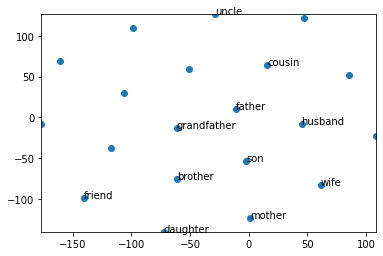

In [ ]:
display_tsne_scatterplot(word_embeddings, 'father')

## 10 Coda: Standard word embeddings vs. contextual word embeddings

The word embeddings explored in this notebook are what you could call *normal* or *standard* word embeddings. These standard word embeddings are context-independent, meaning that each word is represented by just one vector, regardless of how many senses this word actually has and at which sentence positions it actually occurs. For example, in a sentence such as 'He left his **cell** phone in the prison **cell**', the word *cell* has two clearly distinct meanings, but standard word embedding approaches would collapse these different meanings into one single word vector. Contextual word embeddings are an upgraded version of these standard word embeddings, and these upgraded embeddings can be calculated by large neural language models such as Google's [BERT](https://www.aclweb.org/anthology/N19-1423/). BERT generates different embeddings for a word depending on its context, i.e., depending on the sense in which it is used and where in the sentence it occurs. In the example sentence above, BERT would create two different embeddings for the two senses of *cell*. Therefore, contextual word embeddings are more powerful representations than standard word embeddings but at the same time, creating such contextual embeddings is computationally more expensive. (In our main notebooks on MT quality evaluation, BERTScore uses the contextual word embeddings from BERT; however, as you’ll notice in these notebooks, BERTScore also takes quite some time to run.) More information on the difference between standard and contextual word embeddings can be found [here](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).

## 11 Tips for further reading
This was a very brief introduction to the concept of word embeddings. Word embeddings are very powerful tools in the context of natural language processing, and we have merely scratched the surface here. If you would like to dive deeper into the topic, here are some reading tips:  
- [Alammar, Jay (2019): The Illustrated Word2vec](http://jalammar.github.io/illustrated-word2vec/)
- [Collis, Jaron (2017): Glossary of Deep Learning: Word Embeddings](https://medium.com/deeper-learning/glossary-of-deep-learning-word-embedding-f90c3cec34ca)  
- [McCormick, Chris (2016): Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)  
- [McCormick, Chris (2017): Word2Vec Tutorial Part 2 - Negative Sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)